In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
diabetesData = pd.read_csv('diabetes.csv')

In [3]:
print(f"Dataset shape: {diabetesData.shape}")
print(f"Dataset columns: {diabetesData.columns.tolist()}")

Dataset shape: (768, 9)
Dataset columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


In [4]:
# Explore the data
print("Dataset Info:")
print(diabetesData.info())
print("\nTarget variable distribution:")
print(diabetesData['Outcome'].value_counts())
print(f"\nPercentage of positive cases: {diabetesData['Outcome'].mean():.2%}")

# Check for missing values
print("\nMissing values:")
print(diabetesData.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

Target variable distribution:
Outcome
0    500
1    268
Name: count, dtype: int64

Percentage of positive cases: 34.90%

Missing values:
Pregnancies                 0
Glucose                     0
BloodPressure          

In [5]:
# Prepare the data for modeling
X = diabetesData.drop('Outcome', axis=1)  # Features
y = diabetesData['Outcome']  # Target

print("Features:", X.columns.tolist())
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Check for any zero values that might indicate missing data
print("\nColumns with zero values (potential missing data indicators):")
for col in X.columns:
    zero_count = (X[col] == 0).sum()
    zero_percentage = (zero_count / len(X)) * 100
    if zero_count > 0:
        print(f"{col}: {zero_count} zeros ({zero_percentage:.1f}%)")

Features: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Feature matrix shape: (768, 8)
Target vector shape: (768,)

Columns with zero values (potential missing data indicators):
Pregnancies: 111 zeros (14.5%)
Glucose: 5 zeros (0.7%)
BloodPressure: 35 zeros (4.6%)
SkinThickness: 227 zeros (29.6%)
Insulin: 374 zeros (48.7%)
BMI: 11 zeros (1.4%)


In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Training set positive rate: {y_train.mean():.2%}")
print(f"Test set positive rate: {y_test.mean():.2%}")

# Scale the features (important for logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures have been standardized (mean=0, std=1)")

Training set size: 614 samples
Test set size: 154 samples
Training set positive rate: 34.85%
Test set positive rate: 35.06%

Features have been standardized (mean=0, std=1)


In [7]:
# Create and train the logistic regression model using statsmodels
# Add constant term for intercept (statsmodels requirement)
X_train_scaled_sm = sm.add_constant(X_train_scaled)
X_test_scaled_sm = sm.add_constant(X_test_scaled)

# Fit logistic regression with statsmodels
logit_model = sm.Logit(y_train, X_train_scaled_sm)
logit_result = logit_model.fit()

# Make predictions (keep same variable names for compatibility)
y_train_proba = logit_result.predict(X_train_scaled_sm)
y_test_proba = logit_result.predict(X_test_scaled_sm)
y_train_pred = (y_train_proba > 0.5).astype(int)
y_test_pred = (y_test_proba > 0.5).astype(int)

print("Logistic Regression Model Training Complete!")
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

# Display model summary with p-values
print("\n" + "="*60)
print("STATSMODELS LOGISTIC REGRESSION SUMMARY:")
print("="*60)
print(logit_result.summary())

Optimization terminated successfully.
         Current function value: 0.466207
         Iterations 6
Logistic Regression Model Training Complete!
Training Accuracy: 0.7948
Test Accuracy: 0.7143

STATSMODELS LOGISTIC REGRESSION SUMMARY:
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Thu, 17 Jul 2025   Pseudo R-squ.:                  0.2789
Time:                        15:26:51   Log-Likelihood:                -286.25
converged:                       True   LL-Null:                       -396.97
Covariance Type:            nonrobust   LLR p-value:                 1.909e-43
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------

In [8]:
# Detailed model evaluation
print("\nCLASSIFICATION REPORT (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=['No Diabetes', 'Diabetes']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print(f"\nCONFUSION MATRIX (Test Set):")
print(f"                 Predicted")
print(f"                No    Yes")
print(f"Actual No   {cm[0,0]:4d}  {cm[0,1]:4d}")
print(f"Actual Yes  {cm[1,0]:4d}  {cm[1,1]:4d}")

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)  # True Positive Rate
specificity = tn / (tn + fp)  # True Negative Rate
ppv = tp / (tp + fp)  # Positive Predictive Value
npv = tn / (tn + fn)  # Negative Predictive Value

print(f"\nADDITIONAL METRICS:")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Positive Predictive Value: {ppv:.4f}")
print(f"Negative Predictive Value: {npv:.4f}")


CLASSIFICATION REPORT (Test Set):
              precision    recall  f1-score   support

 No Diabetes       0.76      0.82      0.79       100
    Diabetes       0.61      0.52      0.56        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.67       154
weighted avg       0.71      0.71      0.71       154


CONFUSION MATRIX (Test Set):
                 Predicted
                No    Yes
Actual No     82    18
Actual Yes    26    28

ADDITIONAL METRICS:
Sensitivity (Recall): 0.5185
Specificity: 0.8200
Positive Predictive Value: 0.6087
Negative Predictive Value: 0.7593


In [12]:
# Feature importance analysis with p-values from statsmodels
feature_names = X.columns
coefficients = logit_result.params[1:]  # Exclude intercept
p_values = logit_result.pvalues[1:]      # Exclude intercept p-value
std_errors = logit_result.bse[1:]        # Exclude intercept std error
conf_int = logit_result.conf_int().iloc[1:]  # Exclude intercept confidence interval

# Create a comprehensive DataFrame with p-values
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Std_Error': std_errors,
    'P_Value': p_values,
    'Conf_Int_Lower': conf_int[0],
    'Conf_Int_Upper': conf_int[1],
    'Abs_Coefficient': np.abs(coefficients),
    'Significance': ['***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else '' for p in p_values]
}).sort_values('Abs_Coefficient', ascending=False)

print("FEATURE IMPORTANCE WITH P-VALUES:")
print(f"{'Feature':<25} {'Coeff':<8} {'P-Value':<10} {'Sig':<4} {'95% CI':<20}")

for _, row in feature_importance.iterrows():
    direction = "↑" if row['Coefficient'] > 0 else "↓"
    ci_str = f"[{row['Conf_Int_Lower']:.3f}, {row['Conf_Int_Upper']:.3f}]"
    print(f"{row['Feature']:<25} {row['Coefficient']:>7.4f} {direction} {row['P_Value']:>9.6f} "
          f"{row['Significance']:<4} {ci_str}")


feature_importance

FEATURE IMPORTANCE WITH P-VALUES:
Feature                   Coeff    P-Value    Sig  95% CI              
Glucose                    1.1661 ↑  0.000000 ***  [0.901, 1.432]
BMI                        0.7274 ↑  0.000000 ***  [0.464, 0.991]
Pregnancies                0.3805 ↑  0.001757 **   [0.142, 0.619]
DiabetesPedigreeFunction   0.2593 ↑  0.019550 *    [0.042, 0.477]
BloodPressure             -0.2048 ↓  0.063584      [-0.421, 0.012]
Age                        0.1819 ↑  0.133834      [-0.056, 0.420]
Insulin                   -0.1371 ↓  0.268348      [-0.380, 0.106]
SkinThickness              0.0695 ↑  0.581463      [-0.178, 0.317]


,Feature,Coefficient,Std_Error,P_Value,Conf_Int_Lower,Conf_Int_Upper,Abs_Coefficient,Significance
x2,Glucose,1.166076,0.135455,7.396698e-18,0.900589,1.431563,1.166076,***
x6,BMI,0.727371,0.134579,6.489099e-08,0.463600,0.991142,0.727371,***
x1,Pregnancies,0.380497,0.121621,1.756761e-03,0.142124,0.618870,0.380497,**
x7,DiabetesPedigreeFunction,0.259316,0.111062,1.954990e-02,0.041638,0.476994,0.259316,*
x3,BloodPressure,-0.204829,0.110415,6.358441e-02,-0.421238,0.011580,0.204829,
x8,Age,0.181874,0.121318,1.338339e-01,-0.055905,0.419653,0.181874,
x5,Insulin,-0.137079,0.123843,2.683484e-01,-0.379806,0.105649,0.137079,
x4,SkinThickness,0.069504,0.126084,5.814629e-01,-0.177616,0.316623,0.069504,


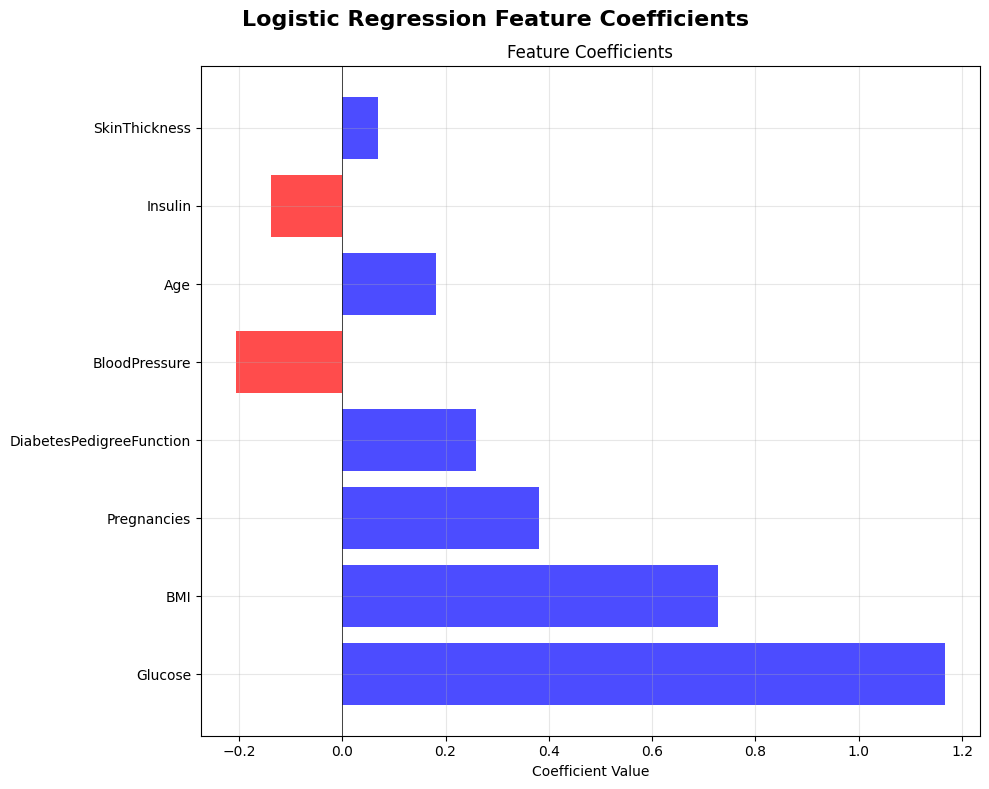

In [10]:
# Visualizations
fig, ax = plt.subplots(figsize=(10, 8))
plt.suptitle('Logistic Regression Feature Coefficients', fontsize=16, fontweight='bold')

# Feature Importance
colors = ['red' if x < 0 else 'blue' for x in feature_importance['Coefficient']]
bars = ax.barh(feature_importance['Feature'], feature_importance['Coefficient'], color=colors, alpha=0.7)
ax.set_title('Feature Coefficients')
ax.set_xlabel('Coefficient Value')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

                    Feature       VIF
7                       Age  1.571712
4                   Insulin  1.535443
3             SkinThickness  1.528619
0               Pregnancies  1.416812
1                   Glucose  1.327608
5                       BMI  1.271591
2             BloodPressure  1.145884
6  DiabetesPedigreeFunction  1.085539



C:\Users\joshua.harvey\AppData\Local\Temp\ipykernel_20684\2377485152.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


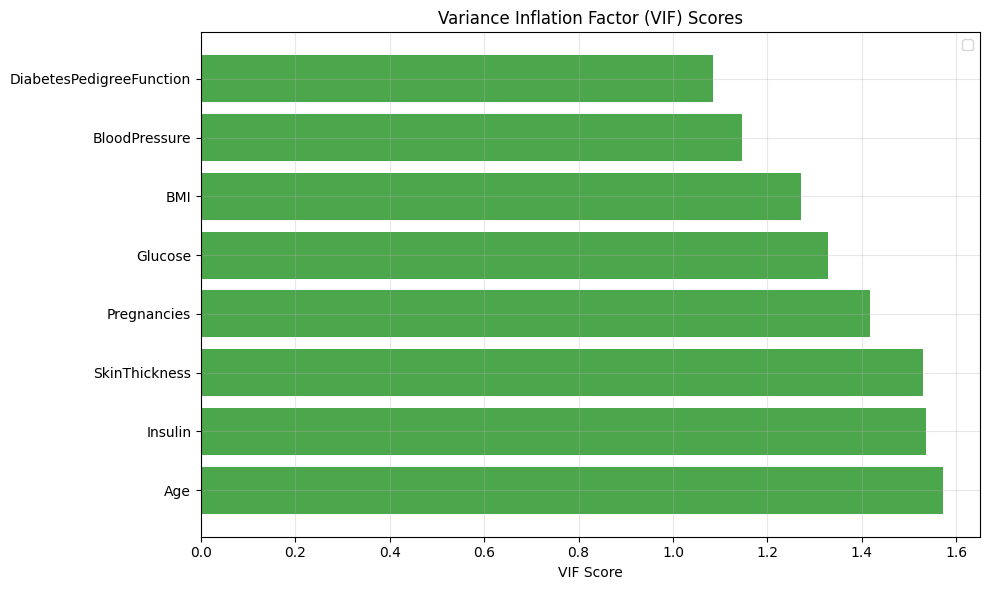

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


def calculate_vif(X_data):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_data.columns
    vif_data["VIF"] = [variance_inflation_factor(X_data.values, i) 
                       for i in range(len(X_data.columns))]
    return vif_data.sort_values('VIF', ascending=False)


# Convert scaled training data back to DataFrame for VIF calculation
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
vif_scores = calculate_vif(X_train_scaled_df)

print(vif_scores)

plt.figure(figsize=(10, 6))
colors = ['red' if x > 10 else 'orange' if x > 5 else 'green' for x in vif_scores['VIF']]
bars = plt.barh(vif_scores['Feature'], vif_scores['VIF'], color=colors, alpha=0.7)
plt.xlabel('VIF Score')
plt.title('Variance Inflation Factor (VIF) Scores')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()